# 3. Classification

## 0. Data Preprocessing

In [1]:
# Basic Library
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

SAMPLE_IDX = 36000
TOTAL_SIZE = 0
TRAIN_SIZE = 60000

In [2]:
def show_img(sample):
    # show sample digit image w/ pyplot
    sample_resize = sample.reshape(28, 28)

    plt.imshow(sample_resize, cmap = matplotlib.cm.binary, interpolation= "nearest")
    # cmap: color map / interpolation: whether to interpolate btw pixels if the display resolution is not the same as the image resolution
    plt.axis("off")
    plt.show()

In [6]:
from sklearn.datasets import fetch_openml

# fetch mnist data
mnist = fetch_openml('mnist_784')
X, y = mnist['data'], mnist['target']
TOTAL_SIZE = X.shape[0]
print(X.shape, y.shape)

(70000, 784) (70000,)


In [7]:
# shuffle and generate train, test set
shuffle_idx = np.random.permutation(TOTAL_SIZE)
X, y = X[shuffle_idx], y[shuffle_idx]
X_train, y_train, X_test, y_test = X[:TRAIN_SIZE], y[:TRAIN_SIZE], X[TRAIN_SIZE:], y[TRAIN_SIZE:]

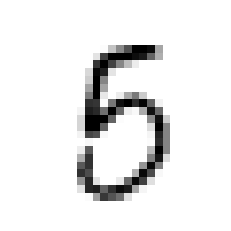

In [8]:
# show sample digit image w/ pyplot
X_sample = X[SAMPLE_IDX]
y_sample = y[SAMPLE_IDX]
show_img(X_sample)

## 3-1. Binary Classification

- binary classifier - 5 or not

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier # SGD Classifier: train instances one by one(online learning)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.base import clone, BaseEstimator

In [ ]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

print("prediction:", sgd_clf.predict([X_sample]))
print("answer:", y_sample)

- measurement
    - StratifiedKFold: performs stratified sampling to produce folds that contain a representative ratio of each class. 

In [ ]:
# measurement of binary classifier
skfolds = StratifiedKFold(n_splits=3)

# measurement 1 : stratifiedKFold
for train_idx, check_idx in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf) # create a clone of classifier
    X_train_folds = X_train[train_idx]
    y_train_fold = y_train_5[train_idx]
    X_check_folds = X_train[check_idx]
    y_check_fold = y_train_5[check_idx]

    clone_clf.fit(X_train_folds, y_train_fold) # train the clone on the training folds
    y_pred = clone_clf.predict(X_check_folds) # make predictions on the check(i.e. the otehr 2 folds) fold
    n_correct = sum(y_pred == y_check_fold)
    print(n_correct/ len(y_pred)) 

In [ ]:
# measurement 2 : cross_val_score
print(cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")) 

In [ ]:
# measurement 3 : compare with dumb classifier
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None): pass
    def predict(self, X): return np.zeros((len(X), 1), dtype = bool)

never_5_clf = Never5Classifier()
print(cross_val_score(never_5_clf, X_train, y_train_5, cv =3, scoring="accuracy")) 

## 3-2. Multiclass Classification

- OvA; One-versus-All

In [ ]:
# scikit-learn automatically runs OvA
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X[SAMPLE_IDX]])

sample_scores = sgd_clf.decision_function([X[SAMPLE_IDX]])
sample_scores

In [ ]:
idx, predicting = np.argmax(sample_scores), sgd_clf.classes_[idx]
idx, predicting

- OvO; One-versus-one

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([X_sample])

# print(len(ovo_clf.estimators_), '\n',ovo_clf.estimators_)

In [ ]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([X_sample])

In [ ]:
forest_clf.predict_proba([X_sample]) 

'''
predict_proba():
   returns an array contatining a row per instance and a column per class, 
   each containing the probability that the given instance belongs to the given class
'''

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

## 3-3. Multilabel Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train = np.array(list(map(int, y_train)))
y_train_large = (y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel = np.c_[y_train_large, y_train_odd] #np.c_ : column 방향으로 데이터 추가

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([X[SAMPLE_IDX]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_macro = f1_score(y_train, y_train_knn_pred, average="macro")
f1_weighted = f1_score(y_train, y_train_knn_pred, average="weighted") # give more weight to the classifier's score depending on its support(i.e. the number of instances with that target label)

In [ ]:
f1_macro

In [ ]:
f1_weighted

## 3-4. Multioutput Classification

: generalization of multilabel classification, each label can be multiclass

In [ ]:
# get rid of noise
noise =np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise =np.random.randint(0, 100, (len(test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn.clf.predict([X_test_mod[SAMPLE_IDX]])


show_img(clean_digit[0])

## 3-5. Measuring Accuracy - using cross validation

### 1) Confuion Matrix

- confusion matrix
    - row: actual class
    - column: predicted class
    - best case: nonzero values only on its main diagonal
    
    
- precision / recall
![alt text](https://hugrypiggykim.com/wp-content/uploads/2018/05/B04223_10_02.jpg)

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

precision, recall

In [ ]:
# decision_function: returns score for each instance
y_scores = sgd_clf.decision_function([X_train[SAMPLE_IDX]])
threshold = 0
y_sample_digit_pred = (y_scores > threshold)
y_sample_digit_pred

In [ ]:
# returns predicted labels
# y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) 

#return decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")

### 2) Precision-Recall Curve

- precision / recall tradeoff

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b-")
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()

plot_precision_vs_recall(precisions, recalls)

### 3) ROC curve; Receiver Operating Chracteristic curve

- x: false positive rate, y: true positive rate(=recall)
- the higher the recall(TPR), the more false positives(FPR)

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Posive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

- AUC;Area Under the Curve
    - is used to compare classifiers
    - best = AUC equals to 1

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train,y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

> **precision/recall curve or ROC curve?**  
-PR curve: whenever the positive class is rare or when care more about the false positives than the false negatives  
-ROC curve: otherwise  


>e.g. 5-or-not model may seems to have good ROC curve, but its because there are only a few positives(5s) compared to the negatives (non-5s)

## 3-5. Error Analysis

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray) #Display an array as a matrix in a new figure window.
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray) # row: actual class, column: predicted class
plt.show() # element with white represents confusing pairs